In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# <b><span style='color:#4797ef'>|</span> EDA | III Investigate data before modelling</b>

In [2]:
df = pd.read_csv("../data/df_for_modelling.csv", index_col=0)
df.head()

,FeelsLikeC,maxtempC,mintempC,windspeedKmph,cloudcover,humidity,pressure,visibility,is_holiday,is_weekend,year,season,month,hour,day,week_day,number_of_rides
0,-36,-17,-24,19,61,97,1026,10,0,1,2021,1,2,7,7,Sunday,7
1,-36,-17,-24,20,62,97,1025,10,0,1,2021,1,2,6,7,Sunday,5
2,-35,-17,-24,18,60,97,1027,10,0,1,2021,1,2,9,7,Sunday,14
3,-35,-17,-24,19,60,97,1026,10,0,1,2021,1,2,8,7,Sunday,7
4,-33,-17,-24,17,60,95,1027,10,0,1,2021,1,2,10,7,Sunday,20


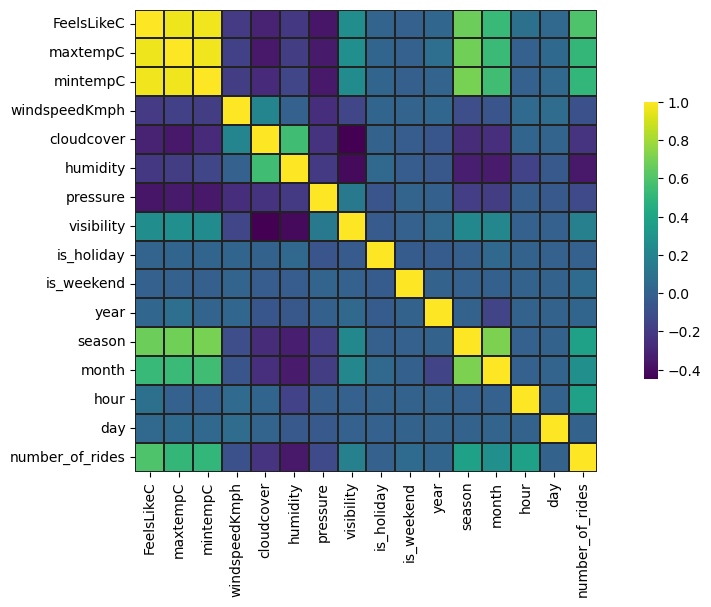

In [3]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.heatmap(df.corr(), cmap="viridis",  # Choose a squential colormap
                 annot_kws={'fontsize': 11},  # Reduce size of label to fit
                 fmt='',          # Interpret labels as strings
                 cbar_kws={"shrink": 0.6},
                 square=True,     # Force square cells
                 linewidth=0.01,  # Add gridlines
                 linecolor="#222")

plt.savefig("../imgs/heatmap_features.png", transparent=True)
plt.show()

**Humidity** and the **cloudcover** has very high correlation within themselves, so it is better to drop one to remove any sort of multicollinearity.

**maxtempC**, **mintempC**, the **feeling temperature** and **season** has very high correlation within themselves, so it is better to leave only 1 column to remove any sort of multicollinearity.

In [4]:
df.drop(['maxtempC', 'mintempC', 'season'], inplace=True, axis=1)

In [5]:
# converting to categorical
df['is_holiday'] = df['is_holiday'].astype('category')
df['is_weekend'] = df['is_weekend'].astype('category')
# df['season'] = df['season'].astype('category')
df['month'] = df['month'].astype('category')
df['day'] = df['day'].astype('category')
df['hour'] = df['hour'].astype('category')
df['week_day'] = df['week_day'].astype('category')

# <b><span style='color:#4797ef'>|</span> Data processing for training</b>

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import r2_score

## Train-test Split

In [7]:
df_train, df_test = train_test_split(df, test_size=.2, random_state=1)

In [8]:
y_train, y_test = df_train['number_of_rides'], df_test['number_of_rides']
for df_ in [df_train, df_test]:
    del df_['number_of_rides'] 
y = y_train.append(y_test, ignore_index = True)

C:\Users\hugom\AppData\Local\Temp\ipykernel_7920\2492945053.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y_train.append(y_test, ignore_index = True)


## One-hot encoding

In [9]:
# Creating dummy variables for the categorical features(One Hot Encoding)
train_dict = df_train.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

In [10]:
# sparse - is a matrix that is comprised of mostly zero values.
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [11]:
X_train = dv.transform(train_dict)
X_test = dv.transform(test_dict)
X = np.concatenate((X_train, X_test))

In [12]:
dv.get_feature_names()

C:\Users\hugom\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['FeelsLikeC',
 'cloudcover',
 'day',
 'hour',
 'humidity',
 'is_holiday',
 'is_weekend',
 'month',
 'pressure',
 'visibility',
 'week_day=Friday',
 'week_day=Monday',
 'week_day=Saturday',
 'week_day=Sunday',
 'week_day=Thursday',
 'week_day=Tuesday',
 'week_day=Wednesday',
 'windspeedKmph',
 'year']

## Feature Scaling

In [13]:
min_max = MinMaxScaler()
min_max.fit(X_train)

MinMaxScaler()

In [14]:
X_train_scaled = min_max.transform(X_train)
X_test_scaled = min_max.transform(X_test)
X_scaled = np.concatenate((X_train_scaled, X_test_scaled))

## Dimensionality Reduction PCA 

In [15]:
pca = PCA(random_state=1)

pca.fit(X_train_scaled)

PCA(random_state=1)

In [16]:
var_cumulative = np.cumsum(pca.explained_variance_ratio_)

C:\Users\hugom\AppData\Local\Temp\ipykernel_7920\316338005.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(var_cumulative,


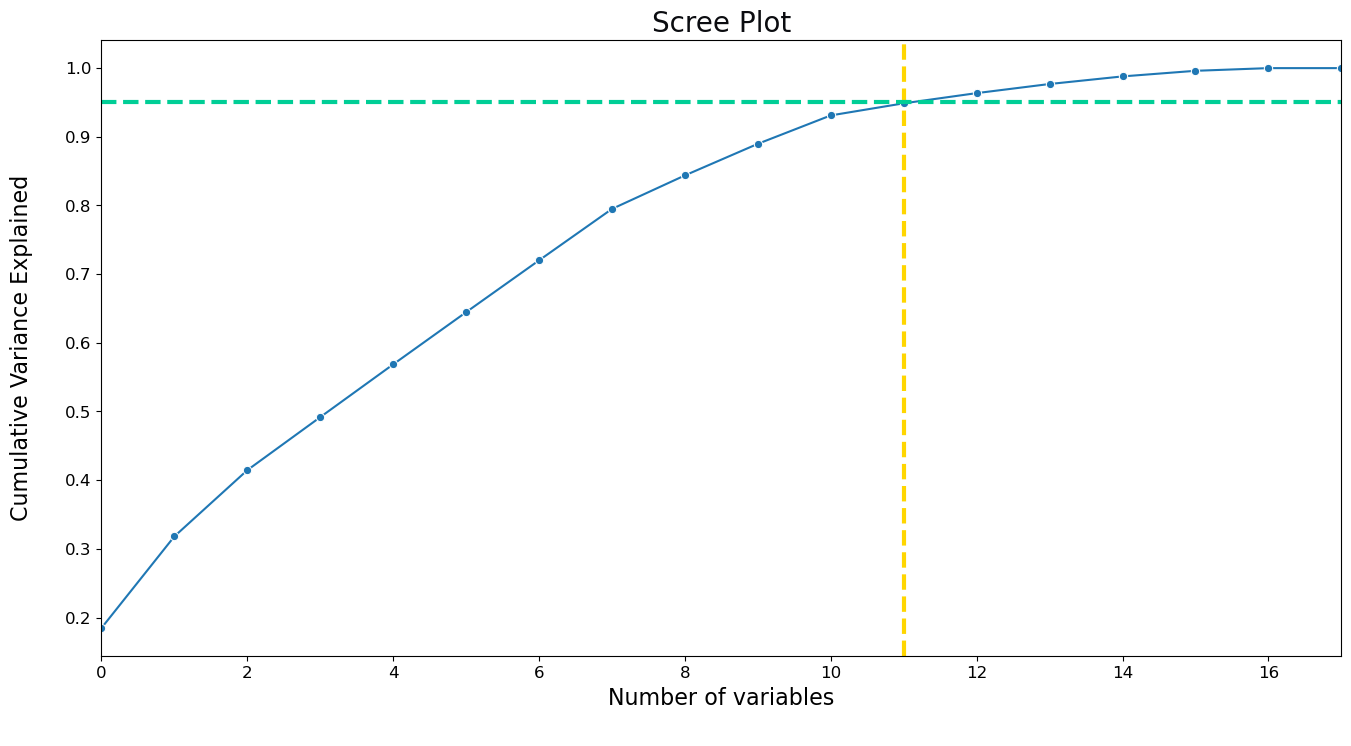

In [17]:
plt.figure(figsize=[16,8])

sns.lineplot(var_cumulative,
             marker='o',
             palette=["#00ce96", "#2a709a"])
plt.axvline(11, color="#ffd600", linestyle='--', linewidth='3')
plt.axhline(0.95, color="#00ce96", linestyle='--', linewidth='3')

plt.title("Scree Plot", size=20, color="#0b0c10")
plt.xlabel("Number of variables\n", size=16)
plt.ylabel("Cumulative Variance Explained\n", size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim(0, 17)

plt.savefig("../imgs/pca_plot.png", transparent=True)
plt.show()

From the Scree Plot we are able to see that almost 95% of the variance is being explained by 11 variables. Therefore, we are going to use IncrementalPCA from Scikit Learn now to transform only 11 variables.

In [18]:
pca_final = IncrementalPCA(n_components=11) # Specifying the n_components to 17 as per Scree Plot

df_pca = pca_final.fit_transform(X_scaled) # Always fit_transform() on train data

df_train_pca = pca_final.fit_transform(X_train_scaled) # Always fit_transform() on train data

df_test_pca = pca_final.transform(X_test_scaled)# Always transform() on test data

# <b><span style='color:#4797ef'>|</span> Modelling</b>

## Performance tuning (hyperparameters)

In [19]:
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import KFold

from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error)

In [20]:
dt_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor()
etr_reg = ExtraTreesRegressor()
xgb_reg = XGBRegressor()

In [21]:
def evaluate_models(X):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = dict()

    for reg in [dt_reg, rf_reg, etr_reg, xgb_reg]:
        reg_list = []
        for train_idxs, test_idxs in kfold.split(X):
            X_train, X_test = X[train_idxs], X[test_idxs]
            y_train, y_test = y[train_idxs], y[test_idxs]

            reg.fit(X_train, y_train)
            y_pred = reg.predict(X_test)
            reg_list.append(r2_score(y_test, y_pred))
        scores[reg.__class__.__name__] = reg_list
    for key in scores.keys():
        print(f'{key}' + ' ' +
              f'{np.mean(scores[key]):.3f} +- {np.std(scores[key]):.3f}')

In [22]:
# simple X
evaluate_models(X)

DecisionTreeRegressor 0.884 +- 0.005
RandomForestRegressor 0.944 +- 0.003
ExtraTreesRegressor 0.954 +- 0.003
XGBRegressor 0.958 +- 0.002


In [23]:
# scaled X
evaluate_models(X_scaled)

DecisionTreeRegressor 0.883 +- 0.006
RandomForestRegressor 0.944 +- 0.003
ExtraTreesRegressor 0.953 +- 0.004
XGBRegressor 0.958 +- 0.002


In [24]:
# scaled and redundant X
evaluate_models(df_pca)

DecisionTreeRegressor 0.702 +- 0.017
RandomForestRegressor 0.870 +- 0.008
ExtraTreesRegressor 0.899 +- 0.006
XGBRegressor 0.857 +- 0.005


R2 became smaller after applying PCA, let's stop at the scaling step.  
Let's choose **XGBRegressor** as our model

In [25]:
n_estimators = [int(x) for x in np.linspace(100, 1000, 10)]

max_depth = [int(x) for x in np.linspace(6, 30, 5)]

learning_rate = [x for x in np.arange(0.001, 0.4, 0.001)]

# how many observations we need to have in a leaf node
min_child_weight = list(range(1, 10))

xg_grid = dict(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
               min_child_weight=min_child_weight)
print(xg_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [6, 12, 18, 24, 30], 'learning_rate': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001, 0.010000000000000002, 0.011, 0.012, 0.013000000000000001, 0.014000000000000002, 0.015, 0.016, 0.017, 0.018000000000000002, 0.019000000000000003, 0.02, 0.021, 0.022000000000000002, 0.023, 0.024, 0.025, 0.026000000000000002, 0.027000000000000003, 0.028, 0.029, 0.030000000000000002, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036000000000000004, 0.037000000000000005, 0.038, 0.039, 0.04, 0.041, 0.042, 0.043000000000000003, 0.044000000000000004, 0.045, 0.046, 0.047, 0.048, 0.049, 0.05, 0.051000000000000004, 0.052000000000000005, 0.053000000000000005, 0.054, 0.055, 0.056, 0.057, 0.058, 0.059000000000000004, 0.060000000000000005, 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07, 0.07100000000000001, 0.07200000000000001, 0.07300000000000001, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.

In [26]:
xgb_random = RandomizedSearchCV(xgb_reg, param_distributions=xg_grid, cv=5, random_state=1,
                                n_iter=20, scoring="r2", n_jobs=-1, verbose=1)
xgb_random.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.3000...
                                                          0.015, 0.016, 0.017,
                                                          0.0180000000

In [27]:
y_pred_xgb = xgb_random.predict(X_test_scaled)

In [28]:
print("R2 score: ",xgb_random.best_score_)
print("best_params: \n",xgb_random.best_params_)

R2 score:  0.964066190359433
best_params: 
 {'n_estimators': 900, 'min_child_weight': 2, 'max_depth': 6, 'learning_rate': 0.23}


# <b><span style='color:#4797ef'>|</span> Make html</b>

In [29]:
!jupyter nbconvert --to html "modelling+tuning.ipynb"

[NbConvertApp] Converting notebook modelling+tuning.ipynb to html
[NbConvertApp] Writing 777292 bytes to modelling+tuning.html
